Changes to previous version:

- added attribute mol to QiskitNaturePySCFSolver
- put definition of h2_mol outside of get_molecular_integrals
- integrated get_molecular_integrals as function inside of QiskitNaturePySCFSolver
- added calc_gradient function from our other code
- removed rep_energy from calc_gradient. It is already included in the ops, right??
- added and implemented nuc_grad_method attribute to QiskitNaturePySCFSolver, as well as as_scanner attribute and grad function


TODO: add simulator and dR attribute to QiskitNaturePySCFSolver, change dR to self.dR, change everything to atomic units (and then remove conversion factor for force), find out how to stop PySCF from printing loads of useless stuff, tidy up code, find out what the error message about complex numbers means, implement grad.converged attribute 

In [1]:
import numpy as np

from pyscf import ao2mo,gto, scf

from typing import Tuple

from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.mappers import ParityMapper, QubitConverter
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.problems import ElectronicBasis
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo

from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SPSA
from qiskit import BasicAer, Aer
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.opflow import CircuitStateFn, StateFn, PauliExpectation, CircuitSampler
from qiskit.utils import QuantumInstance




class QiskitNaturePySCFSolver:
    ''' 
    Solver class using Qiskit and the VQE algorithm.
    
    Args: 
        mol: Mole
            Mole object from PySCF.
    
    Attributes:
        qubit_op : PauliSumOp
            The sum of Pauli operators representing the Hamiltonian for 
            the current geometry.
            
        converter : QubitConverter 
            A converter from Second-Quantized to Qubit Operators.
            
        norb : int 
            Number of orbitals.
            
        nelec : int 
            Number of electrons.
        
        dR : float
            Space step in unit of Angstrom to compute the gradients.
    '''
    
    def __init__(self, 
                 mol):
        
        self.mol = mol
        self.qubit_op  = None
        self.converter = None
        self.norb = None
        self.nelec = None
        self.dR = 0.02 #step in unit of Angstrom
        
        

    def get_molecular_integrals(self, shifted = False, shifted_mol = None):
        '''
        Calculates the 1-electron and 2-electron integrals.
        
        Args: 
            shifted : bool
                Indicates if we want to compute the integrals for the current geometry
                or for a shifted geometry.
                
            shifted_mol : Mole 
                If shifted is true, then it corresponds to the molecule with the
                shifted geometry.
                
        Returns:
            h1_MO : ndarray
                 Tensor corresponding to the 1-electron integral in the molecular basis.
            
            h2_MO : ndarray
                 Tensor corresponding to the 2-electron integral in the molecular basis.
            
            num_orb : int 
                Number of orbitals.

            n_particles : int 
                Number of electrons.

            nuclear_repulsion_energy : float
                Nuclear repulsion energy.
        '''

        # in the case that no shifted mol is given, compute integrals for self.mol
        if shifted == False:   
            molecule = self.mol
        else:
            molecule = shifted_mol

        mf = scf.RHF(molecule).run()
 
        # computing the 1e and 2e AO (atomic orbitals) integrals 
        h1 = molecule.intor_symmetric("int1e_nuc") + molecule.intor_symmetric("int1e_kin") 
        h2 = molecule.intor("int2e")
        # comment : add aom (axis of symmetry) ???

        # transformations from AO to MO (molecular orbitals)
        h1_MO = np.einsum('pi,pq,qj->ij', mf.mo_coeff, h1, mf.mo_coeff)
        h2_MO = ao2mo.get_mo_eri(h2, mf.mo_coeff)

        #h2_MO = ao2mo.kernel(mol_h2, mf.mo_coeff, aosym="1") #alternative

        nuclear_repulsion_energy=molecule.energy_nuc()
        num_particles = molecule.nelec
        num_orb = h1.shape[0]

        return h1_MO, h2_MO, num_orb, num_particles, nuclear_repulsion_energy

    
    def kernel(self, 
               h1_MO: np.array,
               h2_MO: np.array, 
               norb: int,
               nelec: Tuple[int, int],
               #coords: Sequence[tuple[float, float, float]],
               ecore: float = 0.0,
               **kwargs
    ) -> Operator:
        '''
        Calculates the Hamiltonian as the sum of Pauli operators from 
        the raw 1-electron and 2-electron integrals.
        
        Args:
            h1_MO : ndarray
                 Tensor corresponding to the 1-electron integral in the molecular basis.
            
            h2_MO : ndarray
                 Tensor corresponding to the 2-electron integral in the molecular basis.
            
            norb : int 
                Number of orbitals.

            nelec : int 
                Number of electrons.

            ecore : float
                Nuclear repulsion energy.
        
        Returns:
            qubit_op : PauliSumOp
                sum of Pauli operators corresponding to the Hamiltonian
        '''
        
        self.norb = norb
        self.nelec = nelec

        # Define an ElectronicEnergy instance containing the 1e and 2e integrals
        electronic_energy = ElectronicEnergy.from_raw_integrals(
                h1_MO, ao2mo.restore(1, h2_MO, self.norb)
            )
        electronic_energy.nuclear_repulsion_energy = ecore

        # Define an ElectronicStructureProblem
        problem = ElectronicStructureProblem(electronic_energy)

        second_q_ops = problem.second_q_ops()     # get second quantized operators
        problem.num_spatial_orbitals = self.norb  # define number of orbitals
        problem.num_particles = self.nelec        # define number of particles 
        
        problem.basis = ElectronicBasis.MO # 1e and 2e integrals are expected to be given in the Molecular Orbitals basis
        # TODO raise error if h1 and h2 not in MO basis ? how to check ? add argument to pass the basis ?
        
        """ 
        problem.molecule=MoleculeInfo(symbols=('H','H'), coords=((0.0, 0.0, 0.0),(1.0, 0.0, 0.0)) )
        print(problem.molecule)
        FC_transformer=FreezeCoreTransformer(freeze_core=True)
        problem = FC_transformer.transform(problem)
        """
        # TODO we need to give info about the molecule to use FreezeCoreTransformer 
        # question : how to do it in a smart way ? at the initialization ??
        
        hamiltonian = second_q_ops[0]  # Set electronic part of Hamiltonian
        hamiltonian = (hamiltonian + FermionicOp({"": ecore}, num_spin_orbitals=self.norb)) # add Nuclear Repulsion Energy
        #print("Hamiltonian :\n", hamiltonian) # print for checking purposes
        
        mapper = ParityMapper()  # Set Mapper
        
        # Do two qubit reduction
        converter = QubitConverter(mapper,two_qubit_reduction=True)
        qubit_op = converter.convert(hamiltonian, self.nelec)
        #print("q_op :\n", qubit_op) # print for checking purposes
        
        self.qubit_op  = qubit_op
        self.converter = converter
    
        return qubit_op
    

    def calc_ground_state(self) -> Tuple[CircuitStateFn, float] :
        '''
        Calculates the ground state and the ground energy of the Hamiltonian.
        
        Returns:
            vqe_ground_state : CircuitStateFn
                Ground state of the Hamiltonian.
                
            min_eng : float
                Ground energy of the Hamiltonian.
        '''
        
        # TODO raise error if kernel has not been called previously
        
        backend = Aer.get_backend('qasm_simulator') 
        quantum_instance = QuantumInstance(backend, shots=128)
        optimizer = SPSA(maxiter=100)
        
        init_state = HartreeFock(num_spatial_orbitals=self.norb, 
                                 num_particles=self.nelec, 
                                 qubit_converter=self.converter
                                )
        
        var_form = UCCSD(qubit_converter=self.converter,
                         num_particles=self.nelec,
                         num_spatial_orbitals=self.norb, 
                         initial_state=init_state
                         )

        vqe = VQE(var_form, optimizer, quantum_instance=quantum_instance) 
        vqe_result = vqe.compute_minimum_eigenvalue(self.qubit_op)
        min_eng = vqe_result.eigenvalue.real
        final_params = vqe_result.optimal_parameters 

        vqe_ground = vqe.ansatz.bind_parameters(final_params) 
        vqe_ground_state = CircuitStateFn(vqe_ground)
        
        return vqe_ground_state, min_eng
    
    def calc_shifted_mols(self,index):
        ''' Calculates the shifted molecular geometries for force calculations.
        Input:
        - index: variable deciding which coordinate to shift
        Output:
        - shifted_mol_plus,shifted_mol_minus: copies of self.mol whose coordinates have been shifted by self.dR at 
        coordinate 'index'.
        '''
        shifted_plus = []
        shifted_minus = []
        
        atomic_config_list = self.mol._atom
       
        for (i,(spec,coord)) in enumerate(atomic_config_list):
            coord_ang = tuple([0.529177249*j for j in coord]) 
            shifted_plus.append([spec,coord_ang])
            shifted_minus.append([spec,coord_ang])
        
        #shifted_minus = shifted_plus.copy() ## for some reason even if I do this they are not copies
        
        num_atom = index//3 #which atom needs to be shifted
        pos = index%3 #which coordinate needs to be shifted
        
        
        #can't change tuple, so need to convert it to list, shift, and then convert back to tuple
        shifted_pos_plus = list(shifted_plus[num_atom][1])
        shifted_pos_minus = list(shifted_minus[num_atom][1])
        shifted_pos_plus[pos] += self.dR
        shifted_pos_minus[pos] -= self.dR
           
        shifted_plus[num_atom][1]= tuple(shifted_pos_plus)
        shifted_minus[num_atom][1]= tuple(shifted_pos_minus)

        
        shifted_mol_plus = gto.M(atom=shifted_plus,basis = self.mol.basis,charge = self.mol.charge,
                                 spin = self.mol.spin,symmetry = self.mol.symmetry)
        shifted_mol_minus = gto.M(atom=shifted_minus,basis = self.mol.basis,charge = self.mol.charge,
                                 spin = self.mol.spin,symmetry = self.mol.symmetry)
        
        return shifted_mol_plus, shifted_mol_minus
   
    
    def calc_gradient(self, psi, simulator='qasm'):
        
        num_coords = 3*self.mol.natm
    
        psi_0 = psi
        
        Ha = 4.36e-18 # 1 Hartree in SI units
        angst = 1.0e-10 # 1 Angstrom in unit of meters
        
        if simulator == 'qasm':
            backend = Aer.get_backend('qasm_simulator') 
            q_instance = QuantumInstance(backend, shots=1028)
        elif simulator == "exact":
            backend = BasicAer.get_backend("statevector_simulator")
            q_instance = QuantumInstance(backend)
        else:
            print('Error: simulator should be qasm or exact!')

        gradient = []

        #loop over particles
        for i in range(num_coords):

            #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
            shifted_mol_plus,shifted_mol_minus = self.calc_shifted_mols(i)
            qubit_op_plus = self.kernel(*self.get_molecular_integrals(shifted = True, shifted_mol=shifted_mol_plus))

            #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
            qubit_op_minus = self.kernel(*self.get_molecular_integrals(shifted = True, shifted_mol=shifted_mol_minus))

            #define desired observable (H_+ - H_-)/(2dR) = -force
            Obs = (qubit_op_plus-qubit_op_minus)

            #get the expectation value <psi_0|O|psi_0>¨

            measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0) 
            expectation = PauliExpectation().convert(measurable_expression)  
            sampler = CircuitSampler(q_instance).convert(expectation) 
            g = sampler.eval().real 

            gradient.append(g*Ha*(1/(2*self.dR*angst))*(1/8.2387234983)*1e8)
            # in the dimension of nN to avoid small values.
        grad_np = np.array(gradient) 
        grad_right_shape = np.reshape(grad_np,(self.mol.natm,3))
        grad_list = list(grad_right_shape)
        return grad_list
     
    def nuc_grad_method(self): 
        #needs to be something with attribute as_scanner, so we just return self
        return self
    
    def as_scanner(self):  
        
        '''as_scanner() needs to be something that has attridutes mol, converged and if you give it an argument, 
        it returns e_tot, gradient_of_potential'''
        
        def grad(mol):
            # Function that computes energy and energy gradient given molecular geometry
            self.mol = mol
            qubit_op = self.kernel(*self.get_molecular_integrals()) 
            psi_0, e_tot = self.calc_ground_state()
            gradient = self.calc_gradient(psi_0) 
            return e_tot, gradient
        
        grad.mol = self.mol
        grad.converged = True # Cheating here, but we can fix this later
        return grad

    
    



BOMD Time 0.00
converged SCF energy = -1.06610864931794
converged SCF energy = -1.0716472626551
converged SCF energy = -1.06042298524027
converged SCF energy = -1.06605247547119
converged SCF energy = -1.06605247547119
converged SCF energy = -1.06605247547119
converged SCF energy = -1.06605247547119
converged SCF energy = -1.06042298524027
converged SCF energy = -1.0716472626551
converged SCF energy = -1.06605247547119
converged SCF energy = -1.06605247547119
converged SCF energy = -1.06605247547119
converged SCF energy = -1.06605247547119
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0000000000     0.0000000000     0.0000000000
1 H     1.8897261246     0.0000000000     0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H     0.0000000000     0.0000000000     0.0000000000
1 H     0.0000000000     0.0000000000     

converged SCF energy = -1.10158171664132
converged SCF energy = -1.09754749489289
converged SCF energy = -1.10535829785542
converged SCF energy = -1.10158171664132
converged SCF energy = -1.10158171664132
converged SCF energy = -1.10158171664132
converged SCF energy = -1.10158171664132
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.1371437900    -0.0000000000    -0.0000000000
1 H     1.7520298844    -0.0000000000     0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H     0.0038564781    -0.0000000000    -0.0000000000
1 H    -0.0038821240    -0.0000000000     0.0000000000
----------------------------------------------
Ekin =   0.0275052147564
Epot =  -1.0999009792808
Etot =  -1.0723957645243

BOMD Time 80.00
converged SCF energy = -1.10921536534355
converged SCF energy = -1.11203031660117
converged SCF energy = -1.

converged SCF energy = -1.0919356043738
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.4004288271    -0.0000000000    -0.0000000000
1 H     1.4879454155    -0.0000000000     0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H     0.0013354940    -0.0000000000     0.0000000000
1 H    -0.0013521617    -0.0000000000    -0.0000000000
----------------------------------------------
Ekin =   0.0033177922932
Epot =  -1.1133466682087
Etot =  -1.1100288759156

BOMD Time 150.00
converged SCF energy = -1.08860335266707
converged SCF energy = -1.07817537769086
converged SCF energy = -1.09705800199143
converged SCF energy = -1.08876837356721
converged SCF energy = -1.08876837356721
converged SCF energy = -1.08876837356721
converged SCF energy = -1.08876837356721
converged SCF energy = -1.09705800199143
converged SCF energy = -1.

------------ VelocityVerlet final velocity -----------
         x                y                z
0 H    -0.0044263379    -0.0000000000    -0.0000000000
1 H     0.0043060111     0.0000000000     0.0000000000
----------------------------------------------
Ekin =   0.0350291715239
Epot =  -1.0952563222013
Etot =  -1.0602271506775

BOMD Time 220.00
converged SCF energy = -1.10823962705154
converged SCF energy = -1.11120173573709
converged SCF energy = -1.10484223155377
converged SCF energy = -1.10820058694722
converged SCF energy = -1.10820058694722
converged SCF energy = -1.10820058694722
converged SCF energy = -1.10820058694722
converged SCF energy = -1.10484223155377
converged SCF energy = -1.11120173573709
converged SCF energy = -1.10820058694722
converged SCF energy = -1.10820058694722
converged SCF energy = -1.10820058694722
converged SCF energy = -1.10820058694722
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.16916006

Ekin =   0.0032327550298
Epot =  -1.1296420813014
Etot =  -1.1264093262715

BOMD Time 290.00
converged SCF energy = -1.06287698877853
converged SCF energy = -1.06850183507781
converged SCF energy = -1.05711528626461
converged SCF energy = -1.06282064874494
converged SCF energy = -1.06282064874494
converged SCF energy = -1.06282064874494
converged SCF energy = -1.06282064874494
converged SCF energy = -1.05711528626461
converged SCF energy = -1.06850183507781
converged SCF energy = -1.06282064874494
converged SCF energy = -1.06282064874494
converged SCF energy = -1.06282064874494
converged SCF energy = -1.06282064874494
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H    -0.0163891804    -0.0000000000    -0.0000000000
1 H     1.8949309169    -0.0000000000     0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H    -0.00080983

converged SCF energy = -1.08800645382629
converged SCF energy = -1.08800645382629
converged SCF energy = -1.08800645382629
converged SCF energy = -1.08312662936487
converged SCF energy = -1.09274861342035
converged SCF energy = -1.08800645382629
converged SCF energy = -1.08800645382629
converged SCF energy = -1.08800645382629
converged SCF energy = -1.08800645382629
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0691580902     0.0000000000    -0.0000000000
1 H     1.8008236577    -0.0000000000     0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H     0.0033291118     0.0000000000     0.0000000000
1 H    -0.0034209517    -0.0000000000    -0.0000000000
----------------------------------------------
Ekin =   0.0209305833765
Epot =  -1.1170526436210
Etot =  -1.0961220602445

BOMD Time 370.00
converged SCF energy = -1

converged SCF energy = -1.103606553832
converged SCF energy = -1.103606553832
converged SCF energy = -1.103606553832
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.3570726132     0.0000000000    -0.0000000000
1 H     1.5052383491    -0.0000000000     0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H     0.0030792590     0.0000000000     0.0000000000
1 H    -0.0032090315    -0.0000000000    -0.0000000000
----------------------------------------------
Ekin =   0.0181691810981
Epot =  -1.1002191930146
Etot =  -1.0820500119164

BOMD Time 440.00
converged SCF energy = -1.09365425465661
converged SCF energy = -1.08438267491525
converged SCF energy = -1.10108857989162
converged SCF energy = -1.09379734516192
converged SCF energy = -1.09379734516192
converged SCF energy = -1.09379734516192
converged SCF energy = -1.09379

------------ VelocityVerlet final velocity -----------
         x                y                z
0 H    -0.0047329733     0.0000000000     0.0000000000
1 H     0.0045547954    -0.0000000000    -0.0000000000
----------------------------------------------
Ekin =   0.0396339920517
Epot =  -1.1197295180975
Etot =  -1.0800955260458

BOMD Time 510.00
converged SCF energy = -1.11533010974979
converged SCF energy = -1.11672802453028
converged SCF energy = -1.11332018517572
converged SCF energy = -1.11530749222377
converged SCF energy = -1.11530749222377
converged SCF energy = -1.11530749222377
converged SCF energy = -1.11530749222377
converged SCF energy = -1.11332018517572
converged SCF energy = -1.11672802453028
converged SCF energy = -1.11530749222377
converged SCF energy = -1.11530749222377
converged SCF energy = -1.11530749222377
converged SCF energy = -1.11530749222377
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.20589164

Ekin =   0.0082001428262
Epot =  -1.1265884786901
Etot =  -1.1183883358640

BOMD Time 580.00
converged SCF energy = -1.06405044030689
converged SCF energy = -1.06964481920112
converged SCF energy = -1.05831558307957
converged SCF energy = -1.06399415326478
converged SCF energy = -1.06399415326478
converged SCF energy = -1.06399415326478
converged SCF energy = -1.06399415326478
converged SCF energy = -1.05831558307957
converged SCF energy = -1.06964481920112
converged SCF energy = -1.06399415326478
converged SCF energy = -1.06399415326478
converged SCF energy = -1.06399415326478
converged SCF energy = -1.06399415326478
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H    -0.0330811663     0.0000000000     0.0000000000
1 H     1.8704334778    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H    -0.00159712

converged SCF energy = -1.07550907392674
converged SCF energy = -1.07550907392674
converged SCF energy = -1.07550907392674
converged SCF energy = -1.07014432664697
converged SCF energy = -1.08080280709186
converged SCF energy = -1.07550907392674
converged SCF energy = -1.07550907392674
converged SCF energy = -1.07550907392674
converged SCF energy = -1.07550907392674
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0063684199     0.0000000000     0.0000000000
1 H     1.8308683405    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H     0.0026679511    -0.0000000000     0.0000000000
1 H    -0.0026323595     0.0000000000     0.0000000000
----------------------------------------------
Ekin =   0.0129034978066
Epot =  -1.0950937550701
Etot =  -1.0821902572636

BOMD Time 660.00
converged SCF energy = -1

converged SCF energy = -1.1155897462135
converged SCF energy = -1.1155897462135
converged SCF energy = -1.1155897462135
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.2874647421     0.0000000000     0.0000000000
1 H     1.5544526523    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H     0.0043087176    -0.0000000000     0.0000000000
1 H    -0.0042196675     0.0000000000    -0.0000000000
----------------------------------------------
Ekin =   0.0334092084485
Epot =  -1.1267364845238
Etot =  -1.0933272760753

BOMD Time 730.00
converged SCF energy = -1.10875897694819
converged SCF energy = -1.10352565995357
converged SCF energy = -1.11262347492137
converged SCF energy = -1.10883082818067
converged SCF energy = -1.10883082818067
converged SCF energy = -1.10883082818067
converged SCF energy = -1.10

------------ VelocityVerlet final velocity -----------
         x                y                z
0 H    -0.0037682488     0.0000000000     0.0000000000
1 H     0.0040001203    -0.0000000000    -0.0000000000
----------------------------------------------
Ekin =   0.0277416116822
Epot =  -1.0840305832824
Etot =  -1.0562889716001

BOMD Time 800.00
converged SCF energy = -1.11688643124684
converged SCF energy = -1.11533609340385
converged SCF energy = -1.11748928421673
converged SCF energy = -1.11690169642851
converged SCF energy = -1.11690169642851
converged SCF energy = -1.11690169642851
converged SCF energy = -1.11690169642851
converged SCF energy = -1.11748928421673
converged SCF energy = -1.11533609340385
converged SCF energy = -1.11690169642851
converged SCF energy = -1.11690169642851
converged SCF energy = -1.11690169642851
converged SCF energy = -1.11690169642851
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.27782267

Ekin =   0.0150694230256
Epot =  -1.1358347222346
Etot =  -1.1207652992090

BOMD Time 870.00
converged SCF energy = -1.07446388419067
converged SCF energy = -1.07974147829801
converged SCF energy = -1.06900919199112
converged SCF energy = -1.07440848123832
converged SCF energy = -1.07440848123833
converged SCF energy = -1.07440848123832
converged SCF energy = -1.07440848123833
converged SCF energy = -1.06900919199112
converged SCF energy = -1.07974147829801
converged SCF energy = -1.07440848123833
converged SCF energy = -1.07440848123832
converged SCF energy = -1.07440848123833
converged SCF energy = -1.07440848123832
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0203364216     0.0000000000     0.0000000000
1 H     1.8526083671    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H    -0.00225982

converged SCF energy = -1.06720213419643
converged SCF energy = -1.06720213419643
converged SCF energy = -1.06720213419643
converged SCF energy = -1.06160126689158
converged SCF energy = -1.07276434852111
converged SCF energy = -1.06720213419643
converged SCF energy = -1.06720213419643
converged SCF energy = -1.06720213419643
converged SCF energy = -1.06720213419643
----------- VelocityVerlet final geometry -----------
         x                y                z
0 H     0.0013464045     0.0000000000     0.0000000000
1 H     1.8833139476    -0.0000000000    -0.0000000000
----------------------------------------------
------------ VelocityVerlet final velocity -----------
         x                y                z
0 H     0.0018680681     0.0000000000     0.0000000000
1 H    -0.0017405200    -0.0000000000    -0.0000000000
----------------------------------------------
Ekin =   0.0059882801674
Epot =  -1.1233344270814
Etot =  -1.1173461469140

BOMD Time 950.00
converged SCF energy = -1

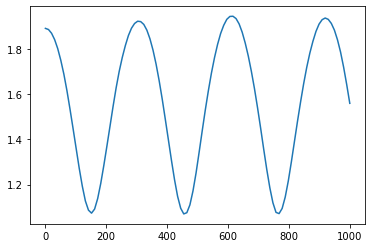

In [2]:
# Test use on hydrogen atom
import matplotlib.pyplot as plt
from pyscf import gto, dft, md


coordinates = [1.0]

mol_h2 = gto.M(
        atom = [['H',(0.0, 0.0, 0.0)], 
                ['H',(coordinates[0], 0.0, 0.0)]],
        basis = 'sto3g',
        charge = 0,
        spin = 0,
        symmetry = False,
    )

mf = QiskitNaturePySCFSolver(mol_h2) #method which computes the energy gradients and energies 
mf.xc = 'pbe,pbe'

coords = []
num_steps = 100
dt = 10 #note: dt is in in atomic units here! 1 is around 2.4*e-17s

#callback function   
def store_intermediate_results(loc):
    coords.append(loc['current_frame'].coord)
    

#Velocity Verlet Algorithm
integrator = md.NVE(mf, dt=dt, steps = num_steps, callback = store_intermediate_results,incore_anyway = True,
                    frames = []).kernel()

np_coords = np.array(coords)
abs_dist = [np.linalg.norm(np_coords[i,0,:]-np_coords[i,1,:]) for i in range(num_steps)]
times = np.linspace(0,dt*num_steps,num_steps)

plt.plot(times, abs_dist)
plt.show()